## Importing Python Libraries
<b>Note : </b>You need to have all these libraries installed, to run this notebook successfully. To download the model you need to uncomment the <i>Download Model</i> section given below.

In [21]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from IPython.display import display, HTML
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from utils import label_map_util
from utils import visualization_utils as vis_util

## Env setup

In [22]:
# This is needed to display the images.
%matplotlib inline
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Model preparation 

In [23]:
MODEL_NAME = 'faster_rcnn_resnet101_coco_2017_11_08'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90 

## Download Model

In [24]:
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#   file_name = os.path.basename(file.name)
#   if 'frozen_inference_graph.pb' in file_name:
#     tar_file.extract(file, os.getcwd())

## Loading Tensorflow model into memory

In [25]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map

In [26]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [27]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Object Detection

In [28]:
# Add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(2, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (10, 7)

In [29]:
def detect_obj():
    with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=3)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
# Filtering results
            L = [category_index.get(value) for index,value in enumerate(classes[0]) if scores[0,index] > 0.1]
            M=[]
            vehicles=['car','bus','truck','motorcycle']
            for i in L:
                if i['name']in vehicles:
                    M.append(i['name'])
            S=set(M)
            text=''
            car=motorcycle=truck=bus=0
            for i in S:
                if i == 'car': car += M.count(i)
                if i == 'motorcycle': motorcycle += M.count(i)
                if i == 'truck': truck += M.count(i)
                if i == 'bus': motorcycle += M.count(i)
                text+=str(i +' : '+ str(M.count(i))+"\t" )
            print('Vehicles Identified -',text)
            calc_pollution(car, motorcycle, truck, bus)

## Setting Emission Factors
Data taken from CPCB document <br>
Values are in in <b>g/km

In [30]:
dict_CO = {'car':0.06, 'motorcycle':1.48, 'truck':0.25, 'bus':3.92}
dict_HC = {'car':0.08, 'motorcycle':0.50, 'truck':0.19, 'bus':0.16}
dict_CO2 = {'car':148.76, 'motorcycle':24.82, 'truck':255.98, 'bus':602.01}
dict_PM = {'car':0.015, 'motorcycle':0.0, 'truck':0.096, 'bus':0.300}

## Calculating Pollution Level

In [31]:
def calc_pollution(car, motorcycle, truck, bus):
    P = []
    co = car*dict_CO['car'] + motorcycle*dict_CO['motorcycle'] + truck*dict_CO['truck'] + bus*dict_CO['bus']
    co2 = car*dict_CO2['car'] + motorcycle*dict_CO2['motorcycle'] + truck*dict_CO2['truck'] + bus*dict_CO2['bus']
    hc = car*dict_HC['car'] + motorcycle*dict_HC['motorcycle'] + truck*dict_HC['truck'] + bus*dict_HC['bus']
    pm = car*dict_PM['car'] + motorcycle*dict_PM['motorcycle'] + truck*dict_PM['truck'] + bus*dict_PM['bus']
    P.extend([co,co2,hc,pm]) 
    print(" CO =", co,'\n',"CO2 =", co2, '\n', "HC =", hc, '\n', "PM10 =", pm)
#     print(P)

## Result
To test with your images put it in the <b>'test_images'</b> folder. Then run it like below two lines with your image name.

Vehicles Identified - car : 12	motorcycle : 4	truck : 3	
 CO = 7.39 
 CO2 = 2652.3399999999997 
 HC = 3.5300000000000002 
 PM10 = 0.468


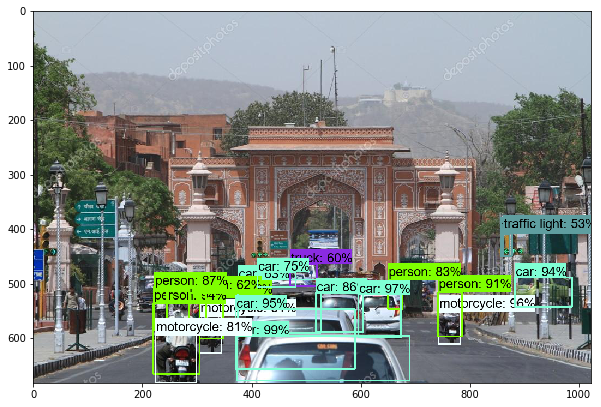

In [32]:
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image1.jpg')]
detect_obj() 

Vehicles Identified - car : 10	motorcycle : 8	truck : 3	bus : 1	
 CO = 14.67 
 CO2 = 2478.92 
 HC = 5.87 
 PM10 = 0.43800000000000006


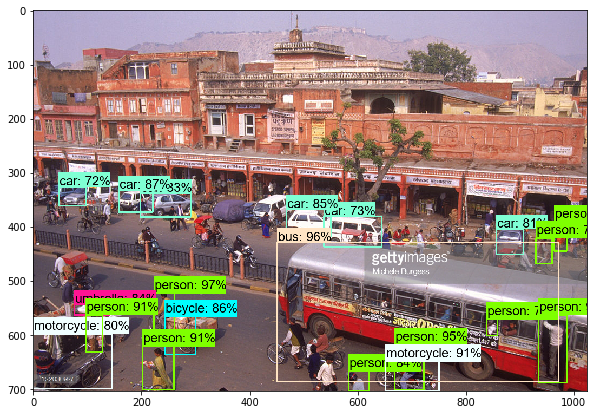

In [33]:
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image2.jpg')]
detect_obj()

Vehicles Identified - car : 15	truck : 3	bus : 7	
 CO = 12.01 
 CO2 = 3173.0799999999995 
 HC = 5.2700000000000005 
 PM10 = 0.513


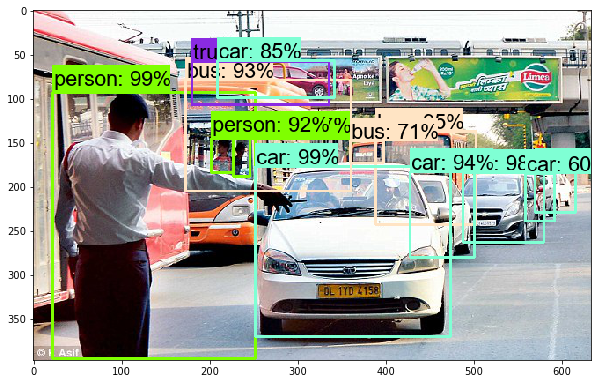

In [34]:
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image3.jpg')]
detect_obj() 

Vehicles Identified - car : 23	motorcycle : 11	truck : 2	bus : 6	
 CO = 27.04 
 CO2 = 4355.379999999999 
 HC = 10.72 
 PM10 = 0.5369999999999999


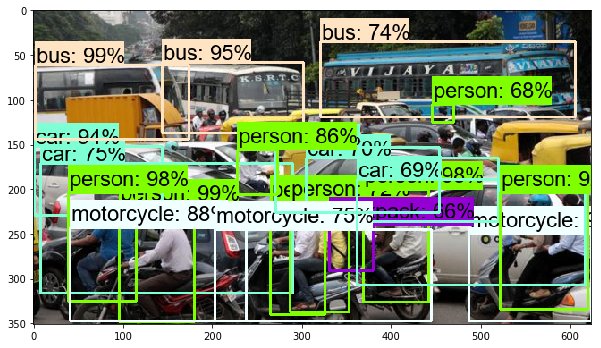

In [35]:
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image4.jpg')]
detect_obj() 

Vehicles Identified - car : 27	motorcycle : 2	truck : 9	bus : 2	
 CO = 9.79 
 CO2 = 6419.619999999999 
 HC = 5.87 
 PM10 = 1.269


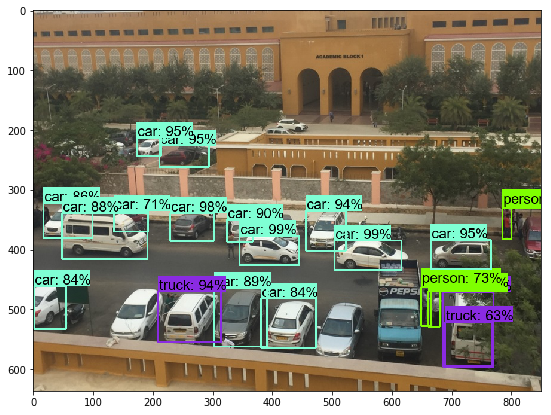

In [36]:
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image5.jpg')]
detect_obj() 

Vehicles Identified - car : 17	motorcycle : 2	truck : 8	bus : 8	
 CO = 17.82 
 CO2 = 4824.96 
 HC = 7.880000000000001 
 PM10 = 1.0230000000000001


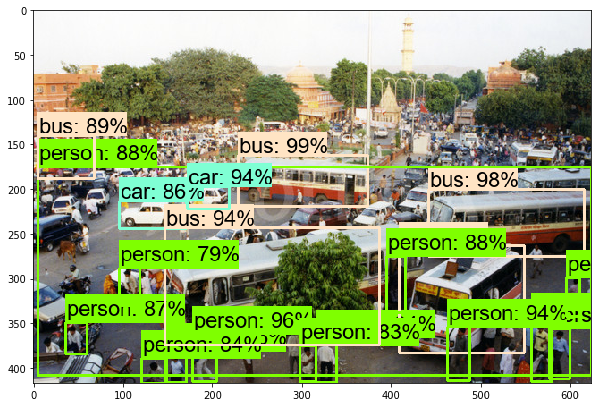

In [37]:
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image6.jpg')]
detect_obj() 